<a href="https://colab.research.google.com/github/vinayp1120/Violence_detection_1/blob/main/Violence_detection_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Objective***:  Classify videos into violent or non-violent categories.
***Dataset***:  Obtained a labeled dataset of violent and non-violent videos.Each video is labeled with either "violent" or "non-violent".
***Preprocessing***:  Each video will be split into frames, then processed as sequences of frames.
Got Dataset from the Kaggle

In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorflow

In [ ]:
'''!kaggle datasets download -d karandeep98/real-life-violence-and-nonviolence-data
!unzip real-life-violence-and-nonviolence-data.zip'''


In [4]:
'''!cd /content/violence_dataset
!mv violence_dataset /content/drive/MyDrive/kaggle_violence'''

'!cd /content/violence_dataset\n!mv violence_dataset /content/drive/MyDrive/kaggle_violence'

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [10]:
# Directory where your dataset is stored
data_dir = '/content/drive/MyDrive/kaggle_violence/violence_dataset'
categories = ['violence', 'non_violence']

# Image dimensions
img_height = 224
img_width = 224


In [11]:
# Load dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    subset='training'  # Use subset='training' for training data
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    subset='validation'  # Use subset='validation' for validation data
)


Found 5481 images belonging to 2 classes.
Found 1370 images belonging to 2 classes.


In [19]:
from tensorflow.keras.models import Model

def build_model(input_shape):
    # Load the VGG16 model pre-trained on ImageNet (without fully connected layers)
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze VGG16 layers to prevent retraining
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Functional API model
    inputs = tf.keras.Input(shape=input_shape)
    x = vgg16_base(inputs, training=False)  # Apply VGG16 base
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
# Input shape: (height, width, channels)
input_shape = (img_height, img_width, 3)  # 3 channels (RGB)

# Build and compile the model
model = build_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,320,514 (62.26 MB)

 Trainable params: 1,605,826 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 84s 355ms/step - accuracy: 0.7892 - loss: 0.5467 - val_accuracy: 0.8534 - val_loss: 0.2738
Epoch 2/10
  1/171 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9375 - loss: 0.1432

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9375 - loss: 0.1432 - val_accuracy: 0.8846 - val_loss: 0.3454
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 47s 270ms/step - accuracy: 0.9346 - loss: 0.1551 - val_accuracy: 0.8571 - val_loss: 0.3303
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.9688 - loss: 0.1135 - val_accuracy: 0.9231 - val_loss: 0.1235
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 46s 260ms/step - accuracy: 0.9639 - loss: 0.1000 - val_accuracy: 0.9263 - val_loss: 0.2191
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 0.8846 - val_loss: 0.3468
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 45s 259ms/step - accuracy: 0.9702 - loss: 0.0804 - val_accuracy: 0.9211 - val_loss: 0.2199
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 1.0000 - loss: 0.0704 - val_accuracy: 0.8846 - val_loss: 0.3623
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.9711 - loss: 0.0660 - val_acc

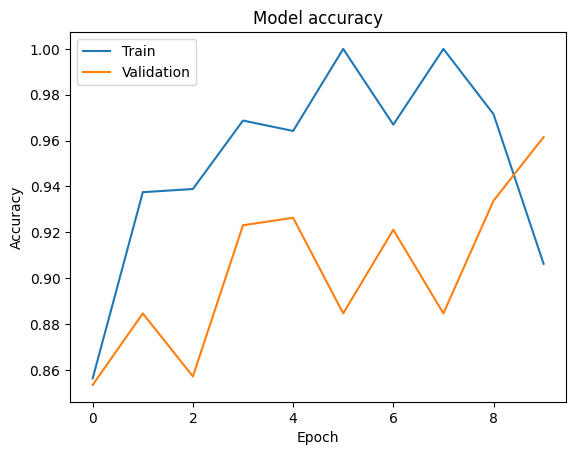

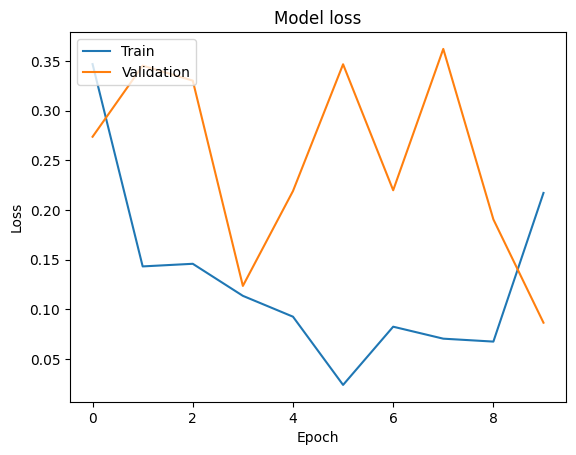

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
# Save the model in .h5 format
model.save('/content/drive/MyDrive/kaggle_violence/vgg16_violence_detection.h5')


In [24]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/kaggle_violence/vgg16_violence_detection.h5')


In [25]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9367 - loss: 0.2060
Validation Loss: 0.20160271227359772
Validation Accuracy: 0.9335766434669495
